In [2]:
# import sys
# !{sys.executable} -m pip install gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import re

In [3]:
stop_words = set(stopwords.words('english'))
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

# Load Data

## Join csv files

In [3]:
df1 = pd.read_csv("all_articles_2015_2016.csv") #2015-2016
df2 = pd.read_csv("all_articles_2017_2018.csv") #2017-2018
df3 = pd.read_csv("all_articles_2019.csv") # 2020
df4 = pd.read_csv("all_articles_2020.csv") # 2020
df5 = pd.read_csv("all_articles_2021_2022.csv") # 2020

In [4]:
df = pd.concat([df1, df2, df3, df4, df5])

In [6]:
# Check that concatination worked correctly
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0] == df.shape[0]

True

In [7]:
# Check that we have no duplicates
df.drop_duplicates().shape[0] == df.shape[0]

True

In [10]:
# Exclude rows with NaN in text column
print(sum(df["story_text"].isna()))
df = df.loc[~df["story_text"].isna(),]

6


In [13]:
df.shape

(54935, 14)

In [14]:
df.to_csv("all_data.csv")

## Some checks of data consistency

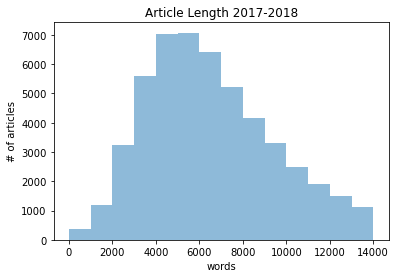

In [12]:
# Check to see distribution of lengths of articles.
length_data = [len(tex) for tex in df['story_text']]

# fixed bin size
bins = np.arange(-0, 15000, 1000) # fixed bin size

plt.hist(length_data, bins=bins, alpha=0.5)
plt.title('Article Length 2017-2018')
plt.xlabel('words')
plt.ylabel('# of articles')

plt.show()

In [223]:
df.head(2)

,url,title,subtitle,n_sections,n_paragraphs,section_titles,story_text,claps,responses,reading_time,publication,date,year
0,https://towardsdatascience.com/kernel-function...,Kernel Functions,NaN,4,31,"['Kernel Functions', 'What is a kernel functio...","Lately, I have been doing some reading up on m...",2500.0,24,6,Towards Data Science,2017-01-02,2017
1,https://towardsdatascience.com/opening-the-neu...,Opening the Neural Network Black Box — Perceptron,NaN,7,21,['Opening the Neural Network Black Box — Perce...,After starting my studies about machine learni...,15.0,1,10,Towards Data Science,2017-01-03,2017


# Preprocessing

In [123]:
#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [124]:
#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==0:
                    stems.append(lowers)
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                stems.append(" ")
    return "".join(stems)

In [125]:
def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

In [126]:
# Exclude the row where story text only consists of NaN
print(df.shape)
df = df.loc[df.story_text.notna(),]
print(df.shape)

(6699, 13)
(6699, 13)


In [127]:
df.year.value_counts()

2018    4528
2017    2171
Name: year, dtype: int64

# Create text per month

In [128]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [129]:
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year

In [130]:
df_month = df.groupby([df.year, df.month])['story_text'].apply(lambda x: ','.join(x)).reset_index()

In [131]:
# Create 
corpus = []
for i, text in enumerate(df_month.story_text):
    processed_text = tokenize(text, 1)
    corpus.append(processed_text)

In [132]:
len(corpus)

24

## Create Word Count Matrix (Skip for now)

In [133]:
%%time
#build vocabulary
vocab, index = {}, 1  # start indexing from 1
for doc in corpus:
    #I added this line from lecture to add tokenization
    tokens = doc.split()
    for token in tokens:
        if token not in vocab:
            vocab[token] = index
            index += 1
        
vocab_stem=vocab
vocab_stem_size = len(vocab)
print(vocab_stem)
print(" ")
print("Total size of stemmed vocabulary:", vocab_stem_size)

{'late': 1, 'read': 2, 'machin': 3, 'learn': 4, 'kernel': 5, 'happen': 6, 'interest': 7, 'part': 8, 'classif': 9, 'problem': 10, 'go': 11, 'topic': 12, 'inspir': 13, 'medium': 14, 'post': 15, 'written': 16, 'alan': 17, 'nlp': 18, 'bot': 19, 'develop': 20, 'thank': 21, 'talk': 22, 'need': 23, 'understand': 24, 'term': 25, 'like': 26, 'svm': 27, 'support': 28, 'vector': 29, 'supervis': 30, 'blah': 31, 'mani': 32, 'right': 33, 'let': 34, 'discourag': 35, 'knew': 36, 'noth': 37, 'diy': 38, 'exercis': 39, 'walk': 40, 'togeth': 41, 'exact': 42, 'ml': 43, 'well': 44, 'turn': 45, 'actual': 46, 'lot': 47, 'thing': 48, 'overarch': 49, 'theme': 50, 'best': 51, 'sum': 52, 'oft': 53, 'quot': 54, 'statement': 55, 'made': 56, 'arthur': 57, 'samuel': 58, 'way': 59, 'back': 60, 'field': 61, 'studi': 62, 'give': 63, 'comput': 64, 'abil': 65, 'without': 66, 'explicit': 67, 'program': 68, 'said': 69, 'experi': 70, 'e': 71, 'respect': 72, 'task': 73, 'perform': 74, 'measur': 75, 'p': 76, 'improv': 77, 'tom

In [140]:
vectors=[]
for doc in corpus:
    vectors.append(vectorize(doc, vocab_stem))

KeyboardInterrupt: 

In [ ]:
word_counts = pd.DataFrame(vectors)

In [ ]:
word_counts.head()

# TF-IDF

In [ ]:
cv = TfidfVectorizer(ngram_range = (2,2),norm=None)
cv.fit(corpus)
vectorized_text=cv.transform(corpus)

In [ ]:
vectorized_text

In [ ]:
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

In [ ]:
tfidf = pd.DataFrame(vectorized_text)
tfidf.columns = cv.get_feature_names_out()

In [ ]:
tfidf_t = tfidf.T

In [ ]:
tfidf_t[2].sort_values(ascending=False)

In [ ]:
for i in range(5):
    print(sum(tfidf_t[i]))
    print(tfidf_t[i+1].sort_values(ascending=False).head(25).index[~ tfidf_t[i+1].sort_values(ascending=False).head(25).index.isin(tfidf_t[i].sort_values(ascending=False).head(25).index)])

In [ ]:
tfidf_neural_network = tfidf["neural network"]

# Create the line plot
fig, ax = plt.subplots()
tfidf_neural_network.plot.line(ax=ax)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'neural network' (01.2017 to 12.2018)")
plt.show()

## LDA

In [224]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')

docs = df['story_text'] # map(unicode, df['original_text'])

[nltk_data] Downloading package wordnet to /Users/Miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [225]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_5179/198452781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = docs[idx].lower()  # Convert to lowercase.
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_5179/198452781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


In [227]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [228]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [229]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)


In [230]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [231]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 10451
Number of documents: 6699


In [205]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [206]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.0300.
[([(0.0073121986, 'science'),
   (0.0059315353, 'data_science'),
   (0.005528513, 'ai'),
   (0.0048657656, 'people'),
   (0.0043819067, 'machine_learning'),
   (0.0043174485, 'project'),
   (0.0042827954, 'scientist'),
   (0.004174445, 'me'),
   (0.0040914547, 'team'),
   (0.0040830225, 'were'),
   (0.0037792737, 'who'),
   (0.0037468616, 'had'),
   (0.0036927615, 'thing'),
   (0.0036745681, 'year'),
   (0.0036057844, 'data_scientist'),
   (0.0035754174, 'even'),
   (0.0034077244, 'could'),
   (0.0033015483, 'question'),
   (0.003148612, 'don'),
   (0.0030780775, 're')],
  -0.7893096502088415),
 ([(0.020365369, 'network'),
   (0.020338316, 'image'),
   (0.0121956775, 'layer'),
   (0.010339148, 'neural'),
   (0.009454964, 'training'),
   (0.007832875, 'input'),
   (0.0070191827, 'function'),
   (0.0069578546, 'deep'),
   (0.0066922326, 'output'),
   (0.0065586763, 'neural_network'),
   (0.0046969564, 'deep_learning'),
   (0.0046962644, 'weight'),
   (0.

In [207]:
# visualize the topics with a dataframe

avg_score = []
topic_list = []
for topic in top_topics:
    topic_i = []
    avg_score.append(topic[1])
    for word in topic[0]:
        topic_i.append(word[1])
    topic_list.append(topic_i)
        

In [208]:
df_tops  = pd.DataFrame(topic_list)
df_tops.insert(0, "avg_score", avg_score)
df_tops

,avg_score,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-0.789310,science,data_science,ai,people,machine_learning,project,scientist,me,team,...,who,had,thing,year,data_scientist,even,could,question,don,re
1,-0.934964,network,image,layer,neural,training,input,function,deep,output,...,deep_learning,weight,feature,loss,task,gradient,paper,trained,vector,train
2,-0.944217,word,code,file,python,text,function,create,run,library,...,ll,notebook,list,dataset,article,following,post,below,name,language
3,-1.131957,feature,variable,point,function,algorithm,probability,distribution,plot,dataset,...,test,method,prediction,class,parameter,training,sample,matrix,random,tree
4,-1.349456,user,customer,action,state,system,business,product,based,agent,...,information,process,reward,ai,policy,service,technology,offer,analytics,based_on


Looks like many of our topics are divided not just in subject matter but also in the style of article. The article may be about neural networks, but is it a tutorial in python? A high level discussion on how they work? A review on a neural network textbook? 

All of the stuff below is for estimating the number of topics we should have. I basically copied the code from here: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin but I think in the end it will take way too long to run because it's taking a long time to run even with just 2017-2018. So for now just leaving it commented out. - Miguel
        

In [232]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from gensim.models import LdaModel, CoherenceModel
# from gensim import corpora

In [257]:
# # Considering 1-15 topics, as the last is cut off
# num_topics = list(range(3)[1:])
# num_keywords = 10

# LDA_models = {}
# LDA_topics = {}
# for i in num_topics:
#     LDA_models[i] = LdaModel(
#             corpus=corpus,
#             id2word=id2word,
#             chunksize=chunksize,
#             alpha='auto',
#             eta='auto',
#             iterations=iterations,
#             num_topics=i,
#             passes=passes,
#             eval_every=eval_every
# )
#     shown_topics = LDA_models[i].show_topics(num_topics=i, 
#                                              num_words=num_keywords,
#                                              formatted=False)
#     LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [258]:
# def jaccard_similarity(topic_1, topic_2):
#     """
#     Derives the Jaccard similarity of two topics

#     Jaccard similarity:
#     - A statistic used for comparing the similarity and diversity of sample sets
#     - J(A,B) = (A ∩ B)/(A ∪ B)
#     - Goal is low Jaccard scores for coverage of the diverse elements
#     """
#     intersection = set(topic_1).intersection(set(topic_2))
#     union = set(topic_1).union(set(topic_2))
                    
#     return float(len(intersection))/float(len(union))